In [1]:
#Required Libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ruptures as rpt
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')



## Data Acquisition
### 1. Confirmed Cases

In [2]:
#Initializing my county as assigned in the the spreadsheet
my_county = 'Hennepin'

In [3]:
confirmed_cases = pd.read_csv('data/RAW_us_confirmed_cases.csv')
confirmed_cases.head(2)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/19/22,10/20/22,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18452,18480,18480,18480,18480,18480,18480,18480,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65819,65895,65895,65895,65895,65895,65895,65895,65973,65973


In [4]:
#Filtering out my county using the Admin2 Column
confirmed_cases_county = confirmed_cases[confirmed_cases.Admin2=='Hennepin']
#Extracting date and non-date columns
date_cols = confirmed_cases_county.filter(regex='^\d').columns.tolist()
non_date_cols = list(set(confirmed_cases_county.columns)-set(date_cols))
print('Retaining these columns : ',non_date_cols)
#Pivoting the dataset to create a date column with values as the number of cases
df_confirmed_cases = confirmed_cases_county.melt(id_vars=non_date_cols, 
        var_name="date", 
        value_name="cases")
df_confirmed_cases.info()

Retaining these columns :  ['Long_', 'Lat', 'UID', 'Admin2', 'FIPS', 'code3', 'iso3', 'Combined_Key', 'iso2', 'Province_State', 'Country_Region']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Long_           1011 non-null   float64
 1   Lat             1011 non-null   float64
 2   UID             1011 non-null   int64  
 3   Admin2          1011 non-null   object 
 4   FIPS            1011 non-null   float64
 5   code3           1011 non-null   int64  
 6   iso3            1011 non-null   object 
 7   Combined_Key    1011 non-null   object 
 8   iso2            1011 non-null   object 
 9   Province_State  1011 non-null   object 
 10  Country_Region  1011 non-null   object 
 11  date            1011 non-null   object 
 12  cases           1011 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 102.8+ KB


In [5]:
#These list of columns don't change for the entire dataset, so I am storing them in a separate dictionary 
county_dict = {i:df_confirmed_cases[i].value_counts().index[0] for i in non_date_cols}
print(county_dict)
#Deleting the columns with a single value
df_confirmed_cases.drop(columns=df_confirmed_cases.columns[0:11],inplace=True)
#Final Schema for confirmed cases
df_confirmed_cases.head(2)

{'Long_': -93.47694895, 'Lat': 45.00761521, 'UID': 84027053, 'Admin2': 'Hennepin', 'FIPS': 27053.0, 'code3': 840, 'iso3': 'USA', 'Combined_Key': 'Hennepin, Minnesota, US', 'iso2': 'US', 'Province_State': 'Minnesota', 'Country_Region': 'US'}


,date,cases
0,1/22/20,0
1,1/23/20,0


### 2. Mask Policies

In [6]:
#Reading raw data
mask_policy = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mask_policy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593869 entries, 0 to 1593868
Data columns (total 10 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   State_Tribe_Territory          1593869 non-null  object
 1   County_Name                    1593869 non-null  object
 2   FIPS_State                     1593869 non-null  int64 
 3   FIPS_County                    1593869 non-null  int64 
 4   date                           1593869 non-null  object
 5   order_code                     1593869 non-null  int64 
 6   Face_Masks_Required_in_Public  987555 non-null   object
 7   Source_of_Action               987555 non-null   object
 8   URL                            942295 non-null   object
 9   Citation                       977273 non-null   object
dtypes: int64(3), object(7)
memory usage: 121.6+ MB


In [7]:
#Extracting my county values 
df_county_policy = mask_policy.loc[mask_policy.County_Name==county_dict['Admin2']+' County',:]
df_county_policy.head(2)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
356440,MN,Hennepin County,27,53,4/10/2020,2,NaN,NaN,NaN,NaN
356441,MN,Hennepin County,27,53,4/11/2020,2,NaN,NaN,NaN,NaN


### Mask Adherence Survey

In [8]:
#Reading Raw Data
mask_survey = pd.read_csv('data/mask-use-by-county.csv')
mask_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   COUNTYFP    3142 non-null   int64  
 1   NEVER       3142 non-null   float64
 2   RARELY      3142 non-null   float64
 3   SOMETIMES   3142 non-null   float64
 4   FREQUENTLY  3142 non-null   float64
 5   ALWAYS      3142 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 147.4 KB


In [9]:
#Extracting values for my county
mask_survey_county = mask_survey[mask_survey.COUNTYFP == county_dict['FIPS']] #using FIPS code
mask_survey_county

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1340,27053,0.021,0.044,0.096,0.243,0.596


In [10]:
#Checking if values sum to one
mask_survey_county.iloc[:,1:].sum(axis=1)

1340    1.0
dtype: float64

## Data Cleaning
### Confirmed Cases

In [11]:
df_confirmed_cases.date

0        1/22/20
1        1/23/20
2        1/24/20
3        1/25/20
4        1/26/20
          ...   
1006    10/24/22
1007    10/25/22
1008    10/26/22
1009    10/27/22
1010    10/28/22
Name: date, Length: 1011, dtype: object

In [12]:
#converting date to datetime format
df_confirmed_cases.date=pd.to_datetime(df_confirmed_cases.date)
#Dates range from 22nd Jan 2020 to 28th Oct 2022
#Extracting values from Feb 1st 2020 to Oct 1 2022
df_confirmed_cases = df_confirmed_cases.loc[(df_confirmed_cases['date'] <= pd.to_datetime('10/01/22'))&(df_confirmed_cases['date'] >= pd.to_datetime('02/01/20')),:].copy()
print('Range '+ str(df_confirmed_cases.date.min()) + ' to ' + str(df_confirmed_cases.date.max()))
#Checking if nay dates are missing in this range 
pd.date_range(start = '2020-02-01', end = '2022-10-01' ).difference(df_confirmed_cases.date)
#No dates are missing

Range 2020-02-01 00:00:00 to 2022-10-01 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

I have added the following calculated fields :
1. Daily cases : The new cases everyday to understand transmission
2. Slope : The rate of transmission by taking the difference in transmission
3. 14 day Average : Daily data can be too noisy due to delay in case reporting, incubation period and infection period hence, I chose to take the 14 day average to better plot trends. *"These estimates imply that, under conservative assumptions, 101 out of every 10 000 cases (99th percentile, 482) will develop symptoms after 14 days of active monitoring or quarantine."* Source : [ Incubation Period of COVID-19](https://www.acpjournals.org/doi/10.7326/m20-0504)
4. Active/new cases every 14 days
5. Rate of transmission every 14 days
6. Instead of taking the date, I wanted to use a new column - 'Days', that starts from Day 0 of COVID-19. The first date is March 12th as the first case reported in this county was on that date, so I delete the rows preceding that date.

In [13]:
#Calculating daily new cases by taking the day to day case difference
df_confirmed_cases['daily_cases'] = df_confirmed_cases['cases'].sub(df_confirmed_cases['cases'].shift())
df_confirmed_cases['daily_cases'].iloc[0]=df_confirmed_cases['cases'].iloc[0]
#Calculating the change in new cases (rate of change of daily cases) by taking the day to day difference
df_confirmed_cases['slope'] = df_confirmed_cases['daily_cases'].sub(df_confirmed_cases['daily_cases'].shift())
df_confirmed_cases['slope'].iloc[0]=df_confirmed_cases['daily_cases'].iloc[0]
#Calculating the 14 day Average
df_confirmed_cases['14_day_avg'] = df_confirmed_cases['cases'].rolling(window=14).mean().round()
#Calculating the change in cases every 14 days
df_confirmed_cases['new_cases14'] = df_confirmed_cases['14_day_avg'].sub(df_confirmed_cases['14_day_avg'].shift())
df_confirmed_cases['new_cases14'].iloc[0]=df_confirmed_cases['14_day_avg'].iloc[0]
#Calculating the change in the new cases ever y 14 days (rate of change of 14 day new cases)
df_confirmed_cases['slope14'] = df_confirmed_cases['new_cases14'].sub(df_confirmed_cases['new_cases14'].shift())
df_confirmed_cases['slope14'].iloc[0]=df_confirmed_cases['new_cases14'].iloc[0]
#Droping rows till 12th of March
df_confirmed_cases.drop(index=df_confirmed_cases.index[:40], axis=0, inplace=True)
#Resetting the index and creating new column as Days
df_confirmed_cases = df_confirmed_cases.reset_index(drop=True)
df_confirmed_cases = df_confirmed_cases.reset_index(drop=False)
df_confirmed_cases.rename(columns={'index':'days'},inplace=True)

In [14]:
#Final Schema for df_confirmed_cases
df_confirmed_cases.head(5)

,days,date,cases,daily_cases,slope,14_day_avg,new_cases14,slope14
0,0,2020-03-12,1,1.0,1.0,0.0,0.0,0.0
1,1,2020-03-13,1,0.0,-1.0,0.0,0.0,0.0
2,2,2020-03-14,6,5.0,5.0,1.0,1.0,1.0
3,3,2020-03-15,6,0.0,-5.0,1.0,0.0,-1.0
4,4,2020-03-16,22,16.0,16.0,3.0,2.0,2.0


### Mask Policy Data

In [15]:
print('Shape of data : ',df_county_policy.shape)
#Checking missing values
print('\n',df_county_policy.isna().sum())

Shape of data :  (493, 10)

 State_Tribe_Territory              0
County_Name                        0
FIPS_State                         0
FIPS_County                        0
date                               0
order_code                         0
Face_Masks_Required_in_Public    105
Source_of_Action                 105
URL                              105
Citation                         105
dtype: int64


In [16]:
df_county_policy.groupby('order_code')['Face_Masks_Required_in_Public'].value_counts(dropna=False).sort_values()

order_code  Face_Masks_Required_in_Public
2           No                                94
            NaN                              105
1           Yes                              294
Name: Face_Masks_Required_in_Public, dtype: int64

In [17]:
dates = df_county_policy.loc[df_county_policy.URL.isnull(),'date']
dates = pd.to_datetime(dates)
print(dates.dt.year.value_counts())
print(dates.dt.month.value_counts().sort_index())
# starts on April 10th and ends on July 23rd 2020

2020    105
Name: date, dtype: int64
4    21
5    31
6    30
7    23
Name: date, dtype: int64


- 105 records missing  in Citation, URL, Face_Masks_Required_in_Public, Source_of_Action and Face_Masks_Required_in_public columns. <br>
- All the missing values are from order code 2 and they are consecutive dates, so I am dropping all the null values as they these mandates did not have any information regarding the face coverings and hence the previous mask policy would be 'no'.

In [18]:
#These list of columns don't change, so I am storing them in a  dictionary 
for i in ['State_Tribe_Territory','County_Name' ,'FIPS_State','FIPS_County','order_code','Source_of_Action','URL','Citation']:
    county_dict[i] = df_county_policy[i].value_counts().index[0]
#Drop these columns
df_county_policy.drop(columns=['State_Tribe_Territory','County_Name' ,'FIPS_State','FIPS_County','order_code'
                                ,'Source_of_Action','URL','Citation'],inplace=True)       
#Dropping Null Values 
df_county_policy.dropna(inplace=True)                                

In [19]:
#Coverting date to datetime format,renaming 'Face_Masks_Required_in_Public' column and resetting the index
df_county_policy.date = pd.to_datetime(df_county_policy.date)
df_county_policy = df_county_policy.reset_index(drop=True)
df_county_policy.rename(columns={'Face_Masks_Required_in_Public':'masks'},inplace=True)
#Final Schema
df_county_policy.head(2)

,date,masks
0,2020-07-24,Yes
1,2020-07-25,Yes


## Combining Datasets
### Confirmed Cases and Mask Policy

In [20]:
#Recording the dates when the policy changed from 'yes' to 'no' or vice versa
change_points = [str(df_county_policy.iloc[i,0])[:-9] for i in df_county_policy.index-1 if df_county_policy.iloc[i,1]!= df_county_policy.iloc[i-1,1]]
print(change_points)
#Adding a column in confirmed cases with the mask policy values 
ind = [i for i in df_confirmed_cases.index if df_confirmed_cases.iloc[i,1]==pd.to_datetime(change_points[0]) or df_confirmed_cases.iloc[i,1]==pd.to_datetime(change_points[1])]
df_confirmed_cases['masks']=np.nan
for i in range(ind[0],ind[1]+1):
    df_confirmed_cases.iloc[i,-1]=1
df_confirmed_cases['masks']=df_confirmed_cases['masks'].fillna(0)
print(df_confirmed_cases['masks'].value_counts())
#1 for 'yes' and 0 for 'no'
df_confirmed_cases.head(3)

['2020-07-24', '2021-05-14']
0.0    639
1.0    295
Name: masks, dtype: int64


,days,date,cases,daily_cases,slope,14_day_avg,new_cases14,slope14,masks
0,0,2020-03-12,1,1.0,1.0,0.0,0.0,0.0,0.0
1,1,2020-03-13,1,0.0,-1.0,0.0,0.0,0.0,0.0
2,2,2020-03-14,6,5.0,5.0,1.0,1.0,1.0,0.0


In [21]:
#Encoding mask column as categorical
df_confirmed_cases['masks'] = df_confirmed_cases['masks'].astype('category')
df_confirmed_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   days         934 non-null    int64         
 1   date         934 non-null    datetime64[ns]
 2   cases        934 non-null    int64         
 3   daily_cases  934 non-null    float64       
 4   slope        934 non-null    float64       
 5   14_day_avg   934 non-null    float64       
 6   new_cases14  934 non-null    float64       
 7   slope14      934 non-null    float64       
 8   masks        934 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(5), int64(2)
memory usage: 59.5 KB


In [37]:
#Saving the combined file used for further visualizations and analysis
df_confirmed_cases.to_csv('data/finalDataset.csv')

## Visualizing Data

Text(0.5, 0, 'Date')

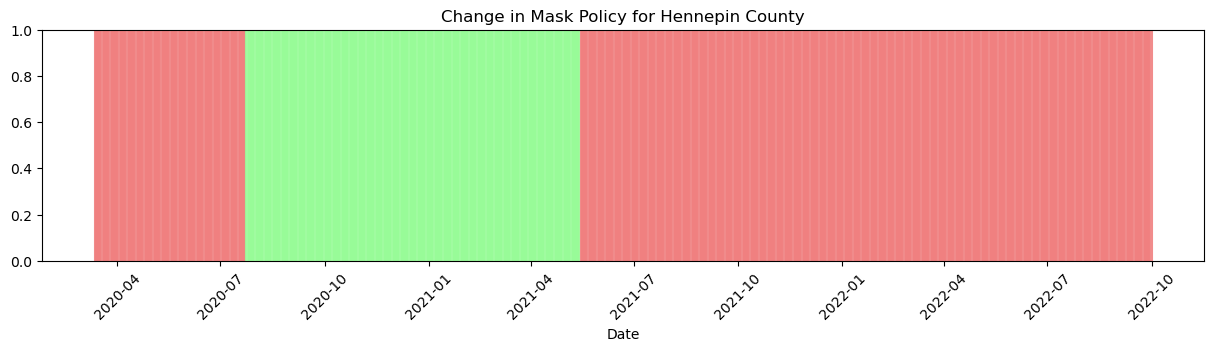

In [22]:
# Mask Policy and Dates
plt.figure(figsize=(15,3))
for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.9)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.9)
plt.xticks(rotation=45)
plt.title('Change in Mask Policy for Hennepin County')
plt.xlabel('Date')

Text(0, 0.5, 'New Daily Cases')

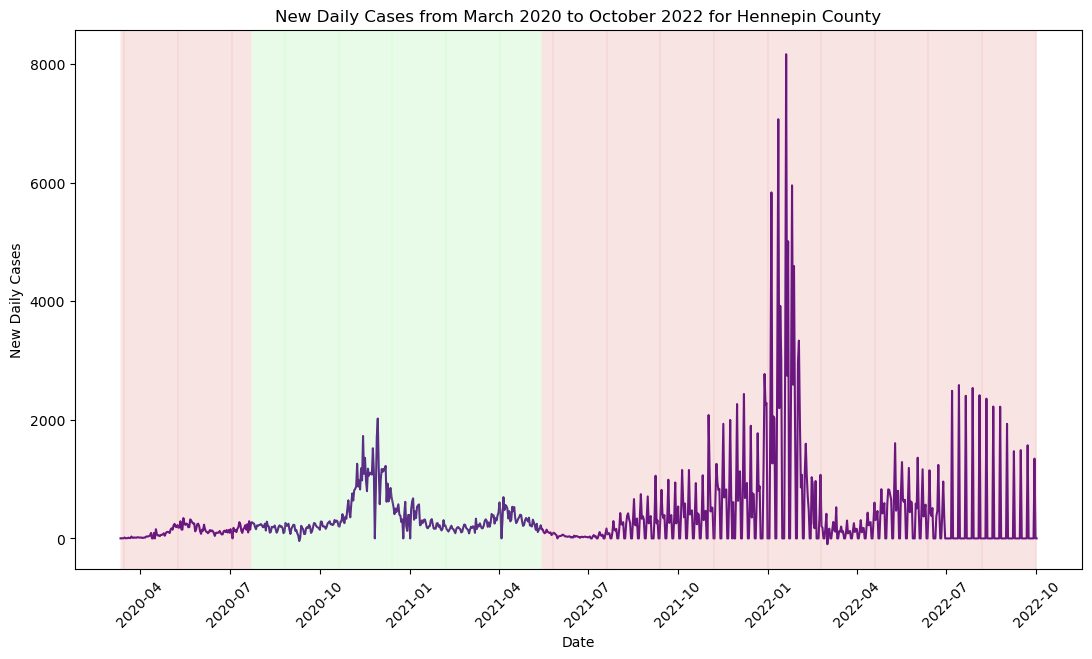

In [23]:
# New Daily cases and date
plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.daily_cases,color='indigo')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('New Daily Cases from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('New Daily Cases')

Text(0, 0.5, 'Change in Daily Cases')

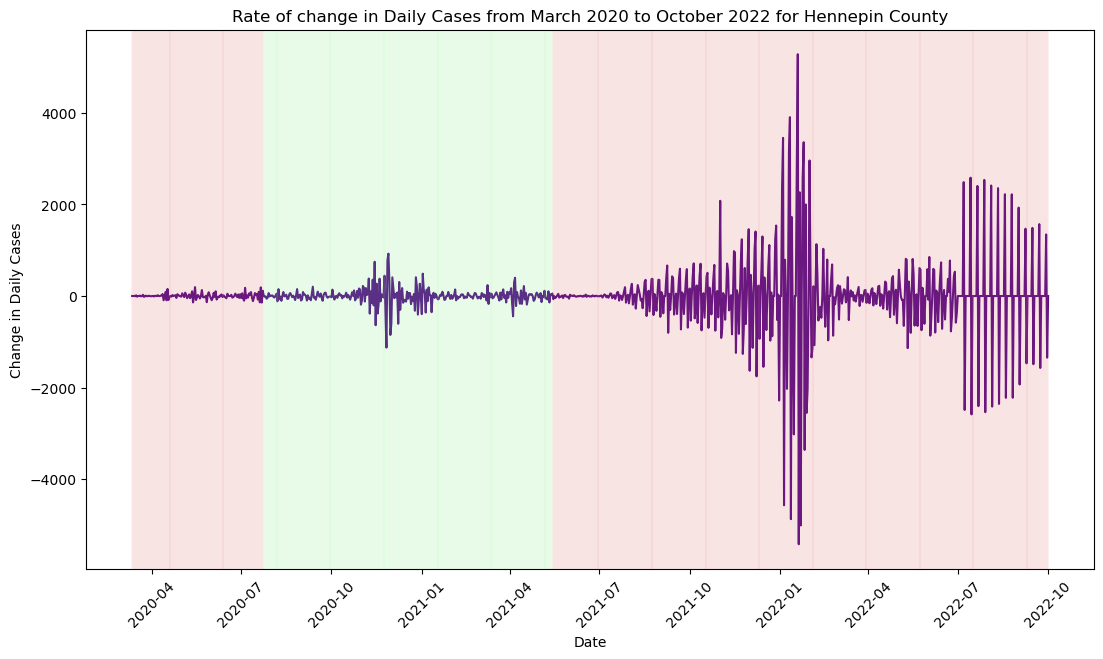

In [24]:
# Change in Rate of Daily cases and date
plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.slope,color='indigo')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('Rate of change in Daily Cases from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('Change in Daily Cases')

Text(0, 0.5, '14 Day Average ')

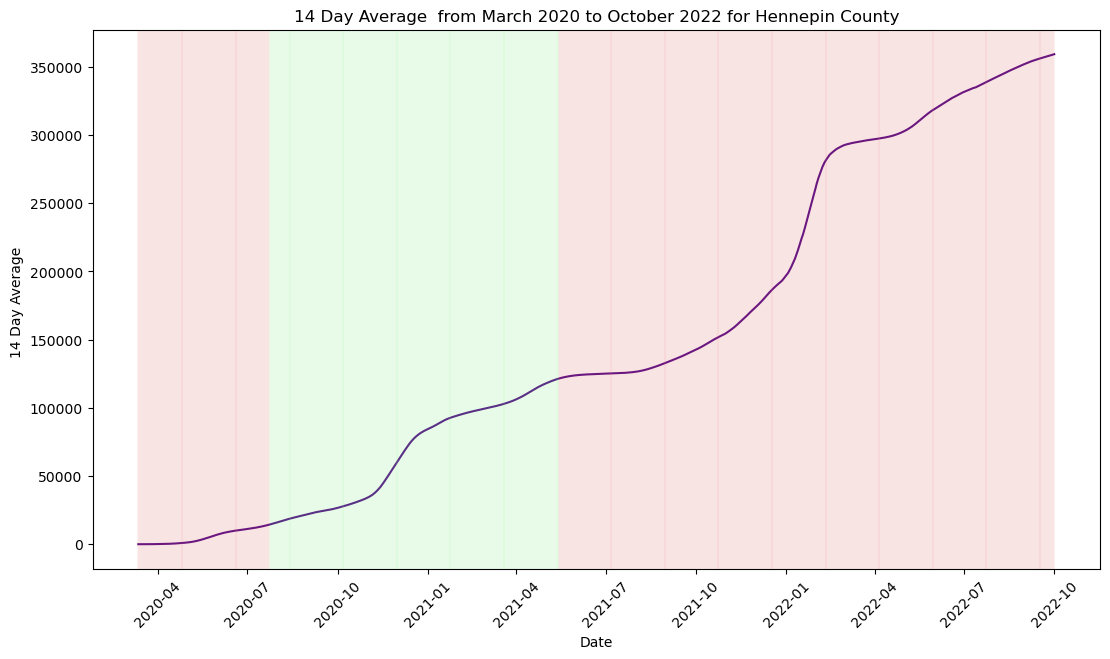

In [25]:
# 14 Day Average and date
plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases['14_day_avg'],color='indigo')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('14 Day Average  from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('14 Day Average ')

Text(0, 0.5, '14 Day Average of daily new cases ')

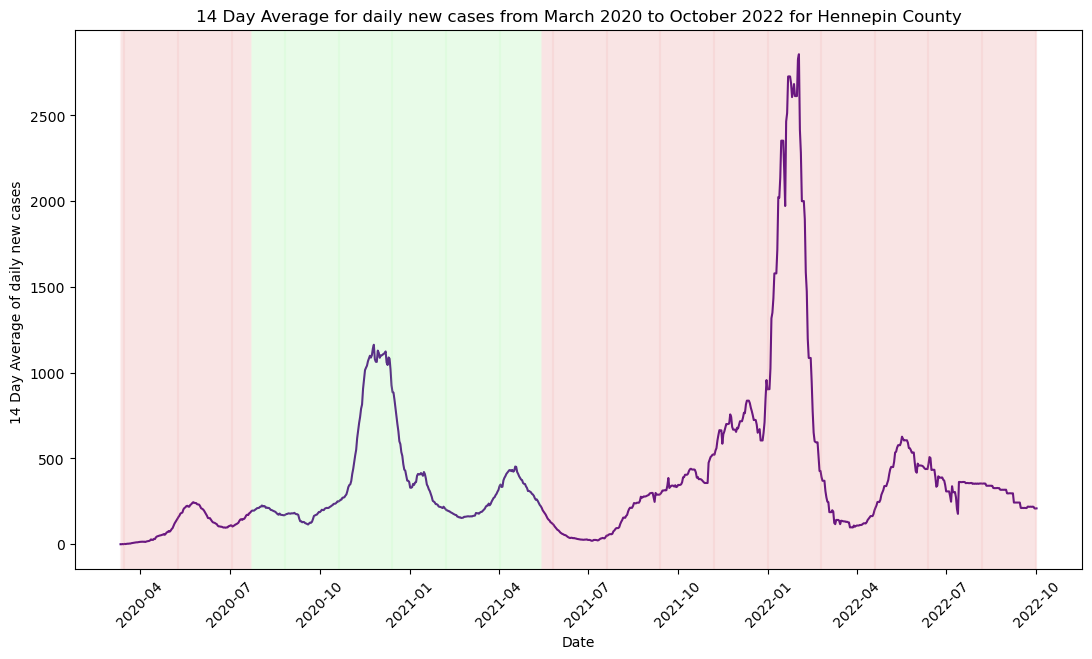

In [26]:
# New cases every 14 Days and date
plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.new_cases14,color='indigo')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('14 Day Average for daily new cases from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('14 Day Average of daily new cases ')

Text(0, 0.5, '14 Day Change in new cases ')

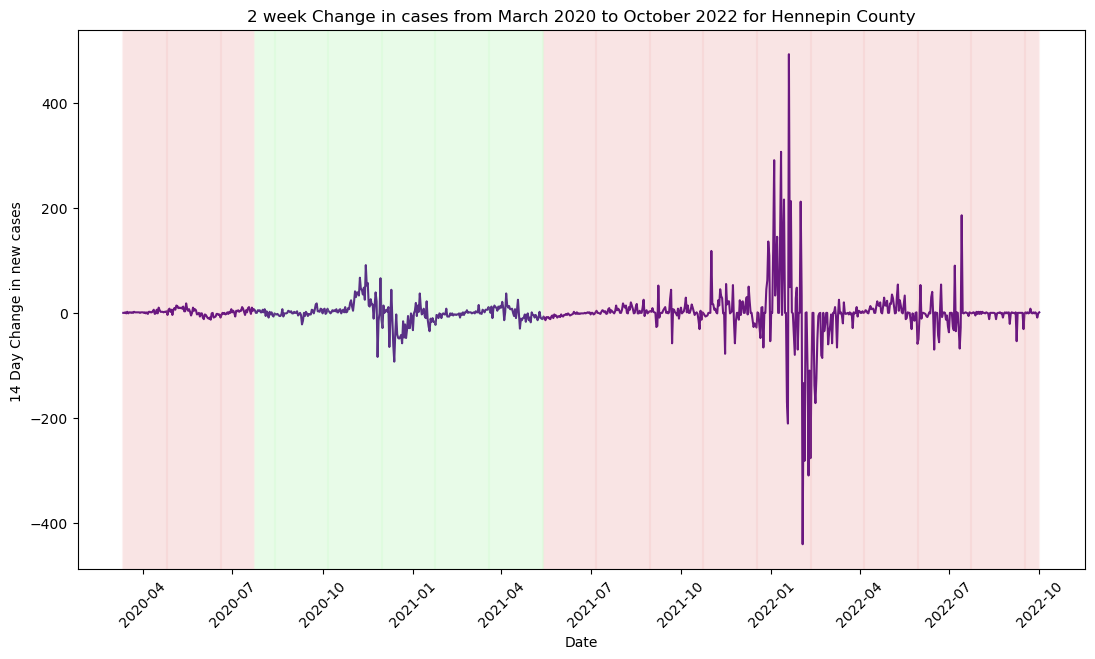

In [27]:
# Change in rate of transmission every 14 days and date
plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.slope14,color='indigo')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('2 week Change in cases from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('14 Day Change in new cases ')

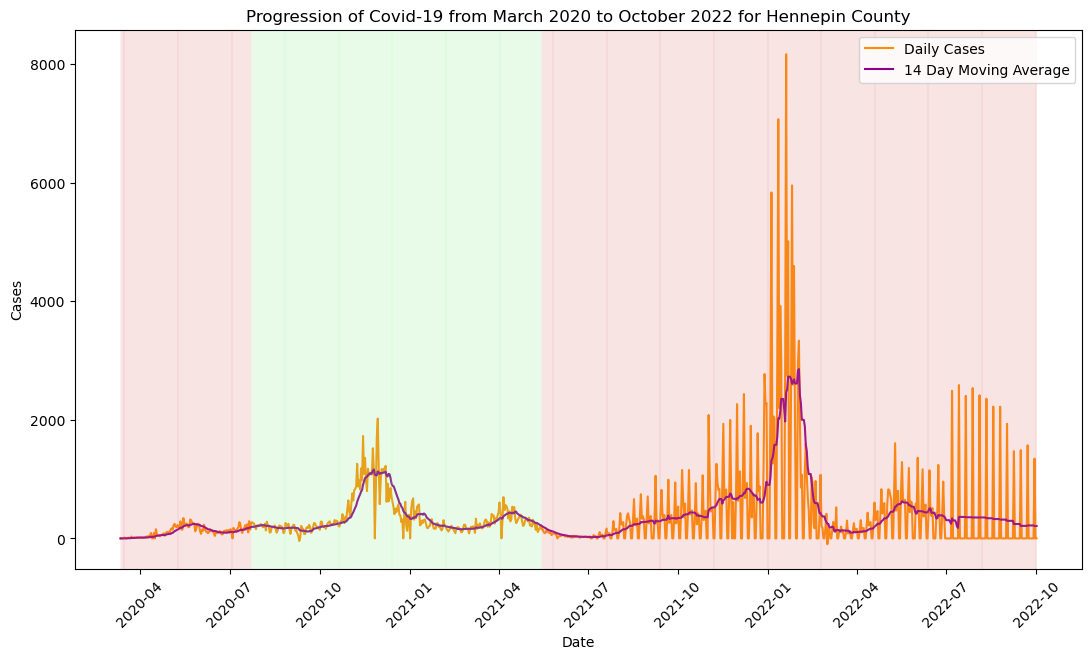

In [28]:

plt.figure(figsize=(13,7))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.daily_cases,color='darkorange',label='Daily Cases')
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.new_cases14,color='darkmagenta',label='14 Day Moving Average')


for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)

plt.xticks(rotation=45)
plt.title('Progression of Covid-19 from March 2020 to October 2022 for Hennepin County')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()

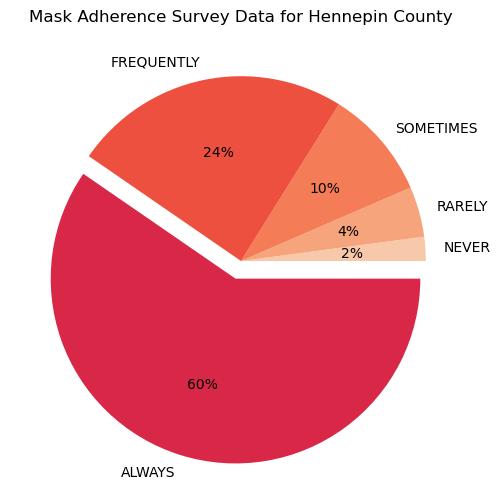

In [29]:
sequential_colors = sns.color_palette("rocket_r", 10)
data = mask_survey_county.iloc[:,1:].values.flatten().tolist()
groups = mask_survey_county.columns[1:].values.flatten().tolist()
explode = [0, 0, 0, 0, 0.1]
plt.figure(figsize=(6,6))
plt.title('Mask Adherence Survey Data for Hennepin County')
plt.pie(data, labels = groups, colors = sequential_colors,  explode=explode, autopct='%.0f%%')
plt.show()

## Modeling

- My idea was to model the exisisting trend using a ML algorithm and then only changing the Mask Mandate variable to see if the trend changes in any significant manner. 
- This model would not be effective for prediction but since i was only going to analyze the date already provided, I chose to go ahead with a random forest model that can learn the exisiting pattern in the data using the calculated and prevailing columns.
- I wanted to predict the daily new cases using the first 2/3rd date and then create test data from the remaining 1/3rd that is identical to the training data schema except the unmasked test data had 0 for all values of masking policy (no policy in affect) and the masked test data had 1 for all values of masking policy (policy is in affect)

Text(0.5, 1.0, 'Correlation')

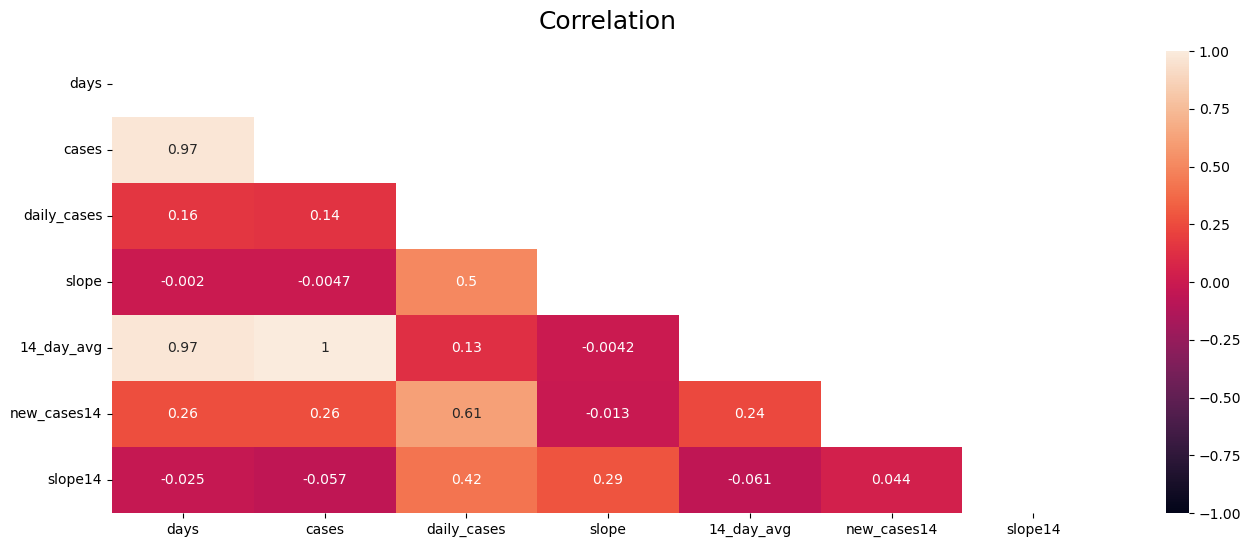

In [30]:
df_linear  = df_confirmed_cases.loc[:,df_confirmed_cases.columns!='date']
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_linear.corr(), dtype=bool))
heatmap = sns.heatmap(df_linear.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16)


In [31]:
#Choosing columns
X = df_linear.loc[:,['days' ,'masks' , '14_day_avg' ,'slope14' , 'new_cases14']]
y =  df_linear.loc[:,['daily_cases']]
#Splitting the dataset into train and test. Shuffle is false because there is ordinal data = Days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

In [32]:
df_preds = pd.DataFrame(columns=['test','test_masked','test_unmasked'])
df_preds['test'] = regressor.predict(X_test)
#Getting predictions for masked dataset
X_test_masked = X_test.copy()
X_test_masked['masks'] = 1
df_preds['test_masked'] = regressor.predict(X_test_masked)
#getting predictions for unmasked dataset
X_test_unmasked = X_test.copy()
X_test_unmasked['masks'] = 0
df_preds['test_unmasked'] = regressor.predict(X_test_unmasked)

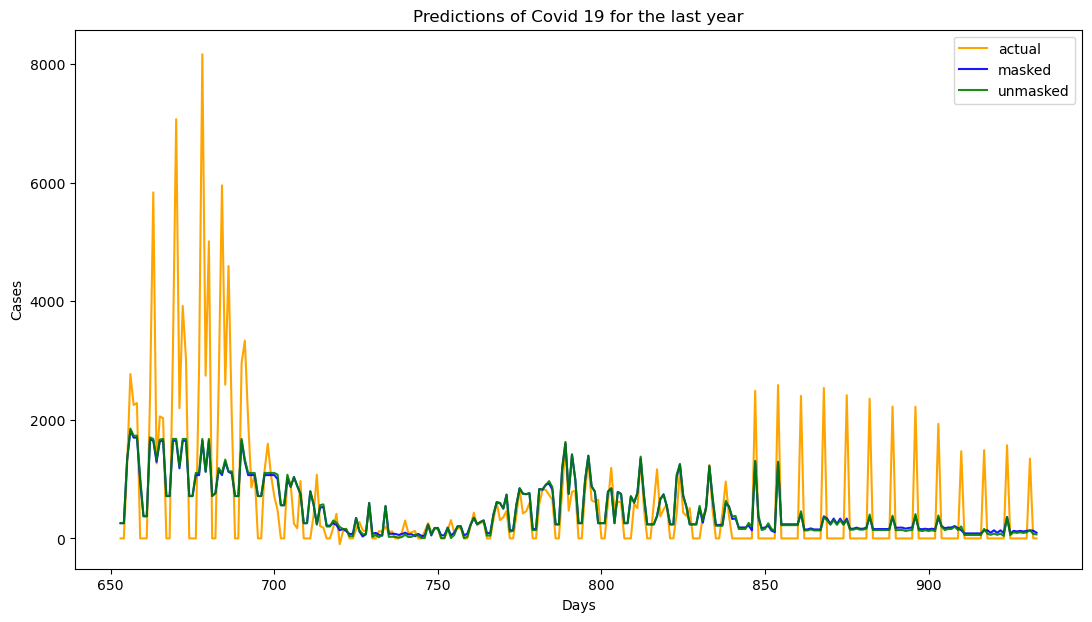

In [33]:
plt.figure(figsize=(13,7))
plt.plot(X_test.days,y_test,color='orange',label='actual')
plt.plot(X_test.days,df_preds.test_masked,color='b',alpha=0.9,label='masked')
plt.plot(X_test.days,df_preds.test_unmasked,color='g',alpha=0.9,label='unmasked')
plt.title('Predictions of Covid 19 for the last year')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()

Text(0, 0.5, 'Change in Cases')

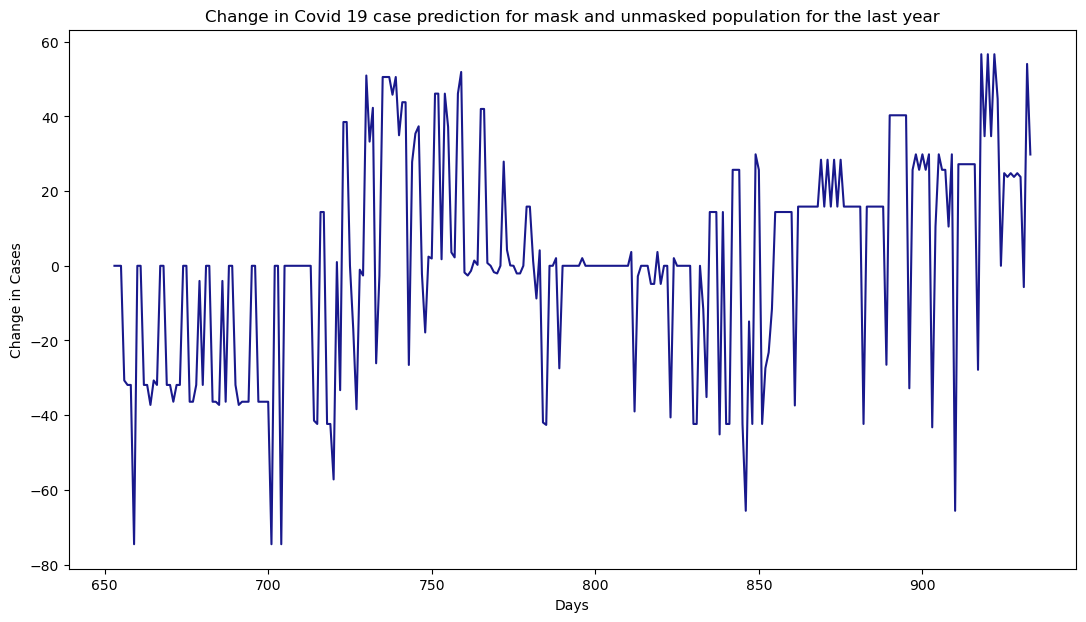

In [34]:
plt.figure(figsize=(13,7))
plt.plot(X_test.days,df_preds.test_masked-df_preds.test_unmasked,color='navy',alpha=0.9)
plt.title('Change in Covid 19 case prediction for mask and unmasked population for the last year')
plt.xlabel('Days')
plt.ylabel('Change in Cases')


We see from the above visualization that unmasked prediction is not very different from the masked prediction, this could be because we have not considered a lot of other important features such as vaccinations etc but also because of my inference from this analysis that mask policy follows a forecast in spike in cases to prevent the situation from getting worse rather than mask mandates causing a decrease in the number of new cases of covid-19

## Collaboration

- Below I have implemented a model introduced by Tharun Reddy in our Discord Group <br>
- The reference for the below implementation can be found [here](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012)

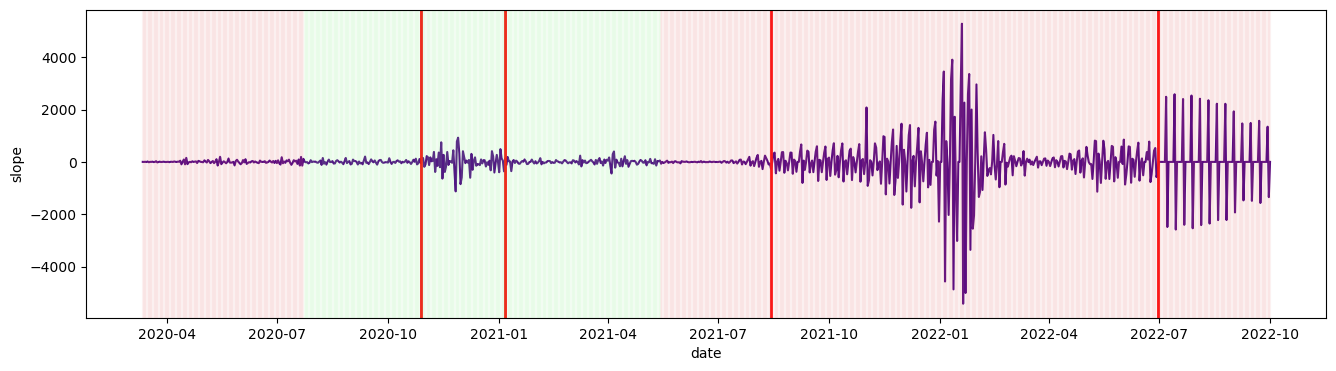

In [35]:
data = np.array(df_confirmed_cases['slope'])

# Detect the change points
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen=6)


change_location1 = change_location1[:-1]
plt.figure(figsize=(16,4))
sns.lineplot(x=df_confirmed_cases.date,y=df_confirmed_cases.slope,color='indigo')
for i in change_location1:
    plt.axvline(df_confirmed_cases.iloc[i,1],lw=2, color='red')
for i in df_confirmed_cases.index:
    if df_confirmed_cases.iloc[i,-1] == 1:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='palegreen',alpha=0.1)
    else:
        plt.axvline(pd.to_datetime(df_confirmed_cases.iloc[i,1]), color='lightcoral',alpha=0.1)


There is a lag in the change point detected by the algorithm and the mask policy change. The predicted change point succeds the mask policy change by  3 months, could be due to the low adherence to mask mandates
.